<a href="https://colab.research.google.com/github/gismo-o/InterviewProject/blob/master/RNN_hisse_senedi_tahmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Yapay Sinir Ağları ile Hisse Senedi Kapanış Fiyatlarının Tahmini ve RNN Tabanlı Modellerin Karşılaştırılması**
- Çalışma, Kaggle platformundan temin edilen “World Stock Prices Dataset” veri seti kullanılarak, NVIDIA hisse senedinin kapanış fiyatlarını tahmin etmeyi amaçlamaktadır. Finansal zaman serisi verileri üzerinde yapay sinir ağları modelleri olan RNN, LSTM, GRU ve Bidirectional RNN mimarileri uygulanmış ve modellerin performansları karşılaştırılmıştır. Veri ön işleme aşamasında eksik değerlerin analizi, ölçeklendirme ve zaman serisi sekanslarının oluşturulması gibi temel işlemler gerçekleştirilmiştir. Model performansları MSE ve RMSE gibi metriklerle değerlendirilmiş, tahmin sonuçları ise grafiklerle görselleştirilmiştir.

In [4]:
from google.colab import files
import pandas as pd

Veri setinin büyüklüğünü ve temel yapısını anlamak için ilk adım.

In [5]:
csv_path = "/content/World-Stock-Prices-Dataset.csv"
df = pd.read_csv(csv_path)

print("Toplam satır sayısı:", len(df))
print(df.info())

Toplam satır sayısı: 309483
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309483 entries, 0 to 309482
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           309483 non-null  object 
 1   Open           309483 non-null  float64
 2   High           309483 non-null  float64
 3   Low            309483 non-null  float64
 4   Close          309483 non-null  float64
 5   Volume         309483 non-null  float64
 6   Brand_Name     309483 non-null  object 
 7   Ticker         309483 non-null  object 
 8   Industry_Tag   309483 non-null  object 
 9   Country        309483 non-null  object 
 10  Dividends      309483 non-null  float64
 11  Stock Splits   309483 non-null  float64
 12  Capital Gains  2 non-null       float64
dtypes: float64(8), object(5)
memory usage: 30.7+ MB
None


Zaman bilgisi sütunu doğru biçime getiriliyor, sütun isimleri temizlenerek veri kalitesi arttırılıyor

In [12]:
# Sütun adlarındaki boşlukları temizle
df.columns = df.columns.str.strip()

# Index'i tekrar string'e çevir ve oradan datetime'a dönüştür
from dateutil import parser
df.index = df.index.map(lambda x: parser.parse(str(x)).astimezone(tz=None).replace(tzinfo=None))

# Kontrol
print("Index türü:", type(df.index))
print("Index eleman tipi:", type(df.index[0]))
print("Örnek tarih:", df.index[0])
print("Başlangıç tarihi:", df.index.min())
print("Bitiş tarihi:", df.index.max())

Index türü: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index eleman tipi: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Örnek tarih: 2025-06-20 04:00:00
Başlangıç tarihi: 2000-01-03 05:00:00
Bitiş tarihi: 2025-06-20 04:00:00


# VERİYİ TANIMA (EDA)

In [13]:
# Veriyi tanıyalım (EDA)
print(df.info())
print(df.head())
print("Sütunlar:", df.columns.tolist())  # veriyi okunabilir hale getirdik
print("Tarih aralığı:", df.index.min(), " - ", df.index.max())
print("Benzersiz şirket sayısı:", df['Brand_Name'].nunique())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309483 entries, 2025-06-20 04:00:00 to 2000-01-03 05:00:00
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Open           309483 non-null  float64
 1   High           309483 non-null  float64
 2   Low            309483 non-null  float64
 3   Close          309483 non-null  float64
 4   Volume         309483 non-null  float64
 5   Brand_Name     309483 non-null  object 
 6   Ticker         309483 non-null  object 
 7   Industry_Tag   309483 non-null  object 
 8   Country        309483 non-null  object 
 9   Dividends      309483 non-null  float64
 10  Stock Splits   309483 non-null  float64
 11  Capital Gains  2 non-null       float64
dtypes: float64(8), object(4)
memory usage: 30.7+ MB
None
                           Open        High         Low       Close  \
Date                                                                  
2025-06-20 04:00:00    6.

In [14]:
# Markaların (şirket isimlerinin) listesi
brands = df['Brand_Name'].unique()
print("Toplam şirket sayısı:", len(brands))
print("Şirketler:")
for i, brand in enumerate(brands[:20], 1):  # İlk 20 tanesini yazdır
    print(f"{i}. {brand}")

Toplam şirket sayısı: 62
Şirketler:
1. peloton
2. microsoft
3. amazon
4. apple
5. nike
6. target
7. google
8. spotify
9. zoom video communications
10. the walt disney company
11. roblox
12. nintendo
13. delta air lines
14. crocs
15. american eagle outfitters
16. foot locker
17. tesla
18. starbucks
19. nvidia
20. salesforce / slack


In [15]:
# Eksik değer kontrolü
print("\nEksik değerler:\n", df.isnull().sum())


Eksik değerler:
 Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Brand_Name            0
Ticker                0
Industry_Tag          0
Country               0
Dividends             0
Stock Splits          0
Capital Gains    309481
dtype: int64


In [16]:
# Sayısal değişken özeti
print("\nSayısal özelliklerin özeti:")
print(df.describe())


Sayısal özelliklerin özeti:
                Open           High            Low          Close  \
count  309483.000000  309483.000000  309483.000000  309483.000000   
mean       76.076210      76.945463      75.187519      76.087226   
std       141.331327     142.866790     139.714237     141.323156   
min         0.000000       0.000000       0.000000       0.198861   
25%        15.910000      16.140988      15.693300      15.919736   
50%        35.333238      35.746418      34.913315      35.342499   
75%        83.631160      84.572708      82.748249      83.665733   
max      3445.580078    3463.070068    3370.000000    3427.610107   

             Volume      Dividends   Stock Splits  Capital Gains  
count  3.094830e+05  309483.000000  309483.000000            2.0  
mean   2.272565e+07       0.003636       0.000876            0.0  
std    8.573243e+07       0.069859       0.115553            0.0  
min    0.000000e+00       0.000000       0.000000            0.0  
25%    1.37800

In [17]:
# Kategorik değişkenler
print("\nBrand_Name örnekleri:", df['Brand_Name'].unique()[:10])
print("Ülke sayısı:", df['Country'].nunique())
print("Ülkeler:", df['Country'].value_counts().head(10))
print("Sektör sayısı:", df['Industry_Tag'].nunique())
print("Sektörler:", df['Industry_Tag'].value_counts().head(10))


Brand_Name örnekleri: ['peloton' 'microsoft' 'amazon' 'apple' 'nike' 'target' 'google' 'spotify'
 'zoom video communications' 'the walt disney company']
Ülke sayısı: 7
Ülkeler: Country
usa            243102
japan           19371
germany         16186
netherlands     12916
france           8859
switzerland      6458
canada           2591
Name: count, dtype: int64
Sektör sayısı: 23
Sektörler: Industry_Tag
technology         66816
retail             25809
automotive         24814
finance            22166
apparel            21028
food & beverage    19376
consumer goods     19374
entertainment      12320
gaming             11515
food               11393
Name: count, dtype: int64


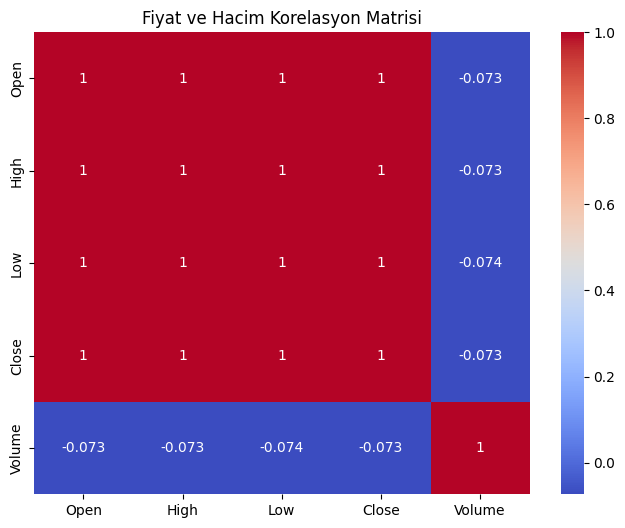

In [18]:
#Fiyatlar arasındaki korelasyon matrisi
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Fiyat ve Hacim Korelasyon Matrisi')
plt.show()


* Open, High, Low, Close fiyatları arasındaki korelasyon 1’e çok yakın, yani çok güçlü pozitif ilişki var
* Volume (işlem hacmi) ile fiyatlar arasında ise zayıf ve negatif bir korelasyon var, yani işlem hacmi fiyat hareketlerini doğrudan güçlü şekilde etkilemiyor





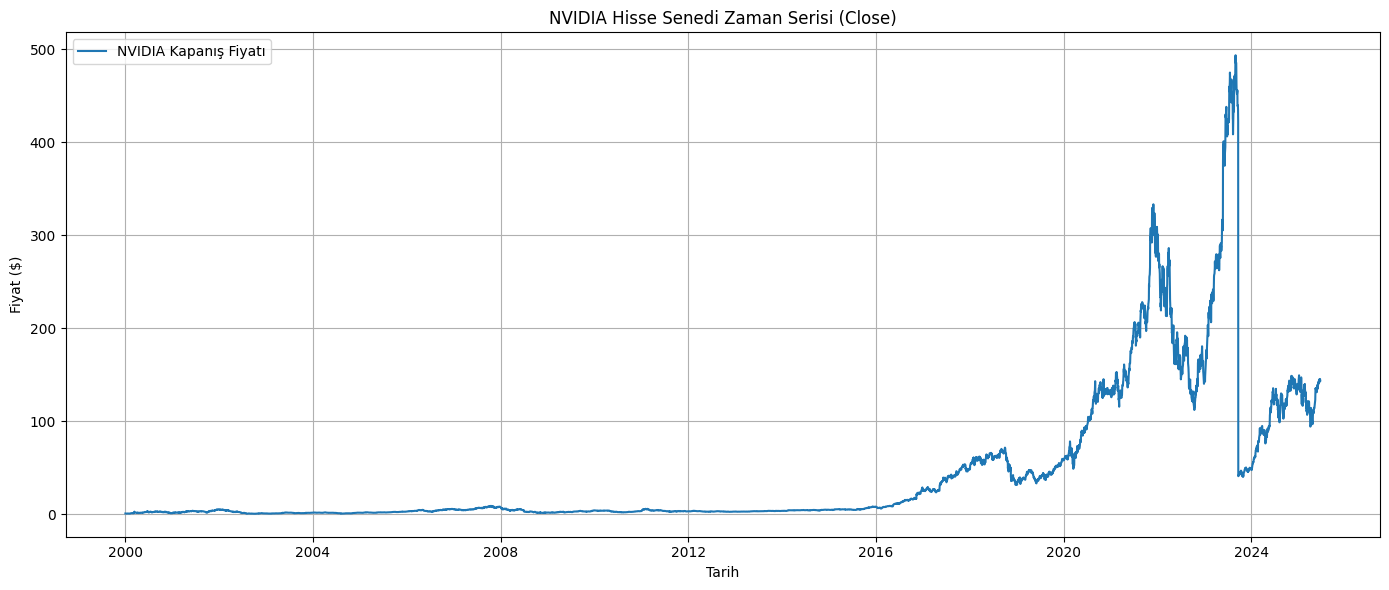

In [19]:
import matplotlib.pyplot as plt

nvidia_df = df[df['Brand_Name'].str.lower() == 'nvidia'].copy() #nvidia filtreleme

# Tarihe göre sıralama (önemli!)
nvidia_df = nvidia_df.sort_index()

# Grafik çizimi
plt.figure(figsize=(14, 6))
plt.plot(nvidia_df.index, nvidia_df['Close'], label='NVIDIA Kapanış Fiyatı')
plt.title('NVIDIA Hisse Senedi Zaman Serisi (Close)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


2020 ve sonrası dönemde NVIDIA hisselerinin kapanış fiyatları belirgin bir yükselişte.

<Axes: >

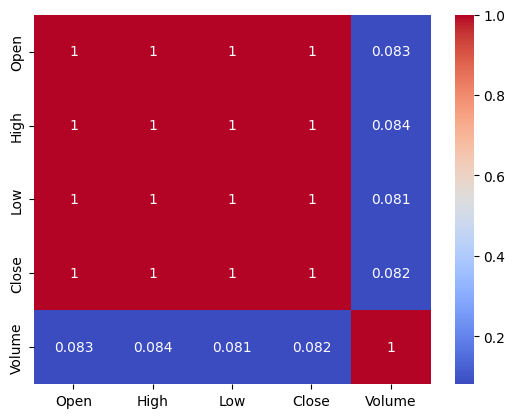

In [20]:
sns.heatmap(nvidia_df[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm') #nvidia korelasyon

Fiyat sütunları yüksek korelasyona sahip olduğundan, model için gereksiz tekrar olabilir. Bu sütunlar arasında seçim yapılabilir..

In [21]:
# NVIDIA verisini filtrele ve tarih sırasına göre sırala
nvidia_df = df[df['Brand_Name'].str.lower() == 'nvidia'].sort_index()

# İlk 5 satırı göster
print(nvidia_df.head())


                         Open      High       Low     Close      Volume  \
Date                                                                      
2000-01-03 05:00:00  0.903091  0.910259  0.843363  0.894729  30091200.0   
2000-01-04 05:00:00  0.879199  0.881589  0.826639  0.870838  30048000.0   
2000-01-05 05:00:00  0.845752  0.860087  0.830223  0.842169  18835200.0   
2000-01-06 05:00:00  0.842168  0.842168  0.754965  0.787218  12048000.0   
2000-01-07 05:00:00  0.783635  0.808720  0.771689  0.800359   7118400.0   

                    Brand_Name Ticker Industry_Tag Country  Dividends  \
Date                                                                    
2000-01-03 05:00:00     nvidia   NVDA   technology     usa        0.0   
2000-01-04 05:00:00     nvidia   NVDA   technology     usa        0.0   
2000-01-05 05:00:00     nvidia   NVDA   technology     usa        0.0   
2000-01-06 05:00:00     nvidia   NVDA   technology     usa        0.0   
2000-01-07 05:00:00     nvidia   NVD

Tarih sırasına göre sıralamak, zaman serisi analizleri için önemli !

Hacimdeki ani artışlar veya düşüşler, fiyat tahmin modellerinde dikkat edilmesi gereken dönemleri gösterebilir

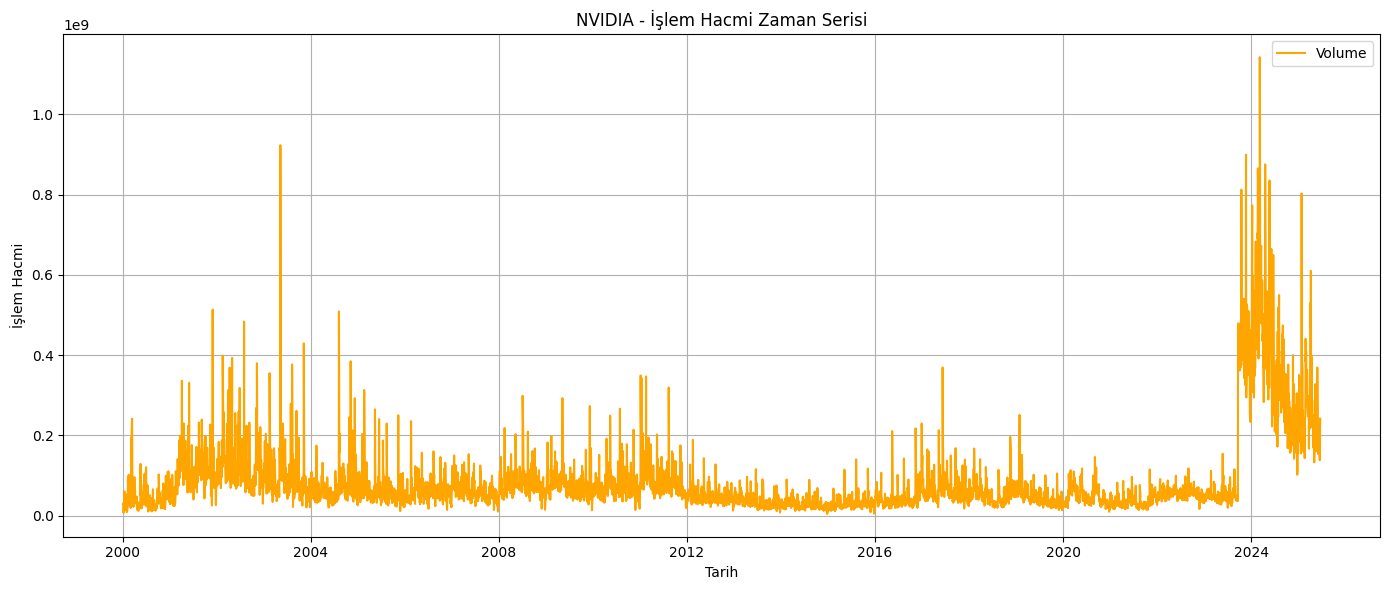

In [22]:
import matplotlib.pyplot as plt

# NVIDIA işlem hacmi zaman serisi grafiği
plt.figure(figsize=(14, 6))
plt.plot(nvidia_df.index, nvidia_df['Volume'], color='orange', label='Volume')
plt.title('NVIDIA - İşlem Hacmi Zaman Serisi')
plt.xlabel('Tarih')
plt.ylabel('İşlem Hacmi')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


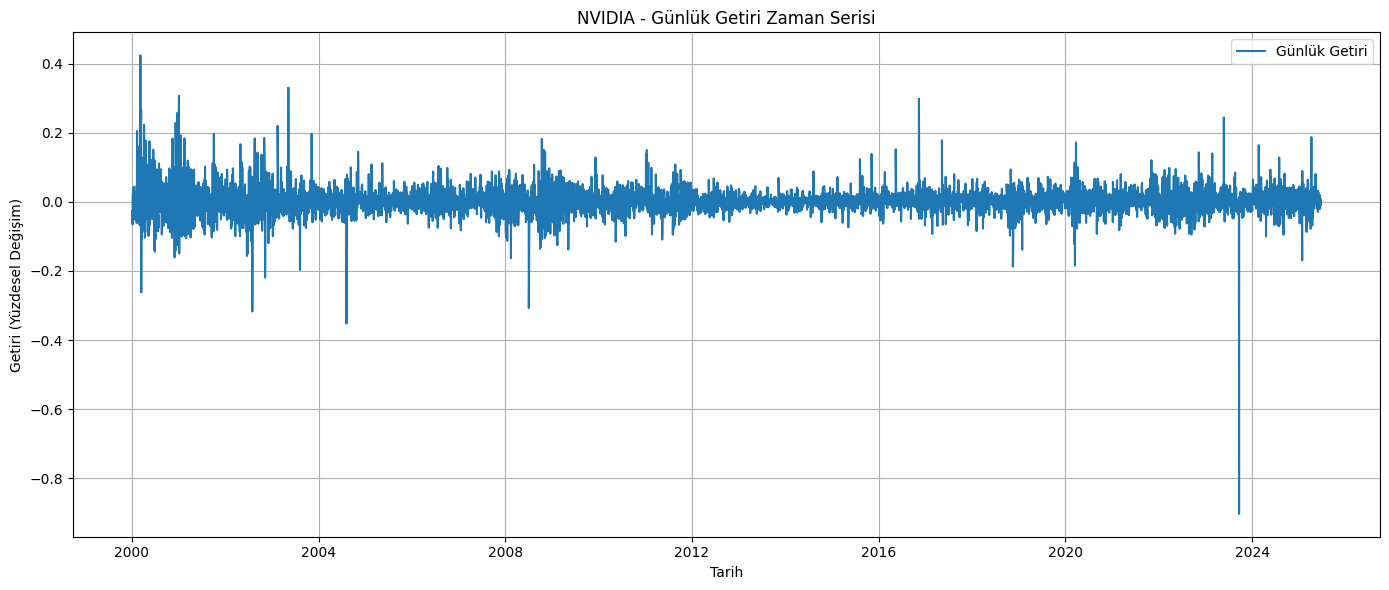

In [23]:
# Günlük getiri hesapla
nvidia_df['Daily_Return'] = nvidia_df['Close'].pct_change()

# Grafik
plt.figure(figsize=(14, 6))
plt.plot(nvidia_df.index, nvidia_df['Daily_Return'], label='Günlük Getiri')
plt.title('NVIDIA - Günlük Getiri Zaman Serisi')
plt.xlabel('Tarih')
plt.ylabel('Getiri (Yüzdesel Değişim)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


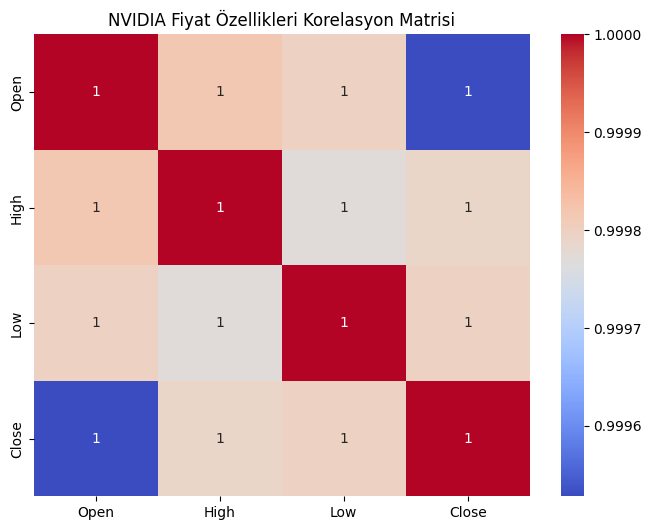

In [24]:
#Fiyatlar arasındaki korelasyon (Open, High, Low, Close)
plt.figure(figsize=(8,6))
sns.heatmap(nvidia_df[['Open', 'High', 'Low', 'Close']].corr(), annot=True, cmap='coolwarm')
plt.title('NVIDIA Fiyat Özellikleri Korelasyon Matrisi')
plt.show()

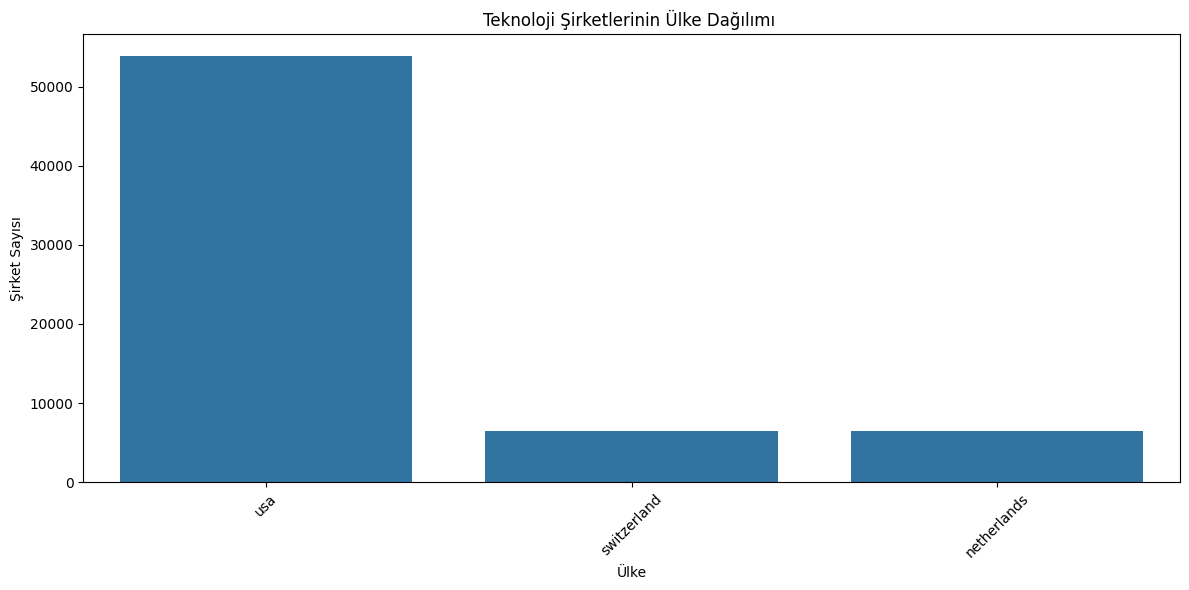

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

tech_df = df[df['Industry_Tag'].str.lower() == 'technology'].copy()
tech_df['Country'] = tech_df['Country'].str.lower()

plt.figure(figsize=(12,6))
sns.countplot(data=tech_df, x='Country', order=tech_df['Country'].value_counts().index)
plt.title('Teknoloji Şirketlerinin Ülke Dağılımı ')
plt.xlabel('Ülke')
plt.ylabel('Şirket Sayısı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


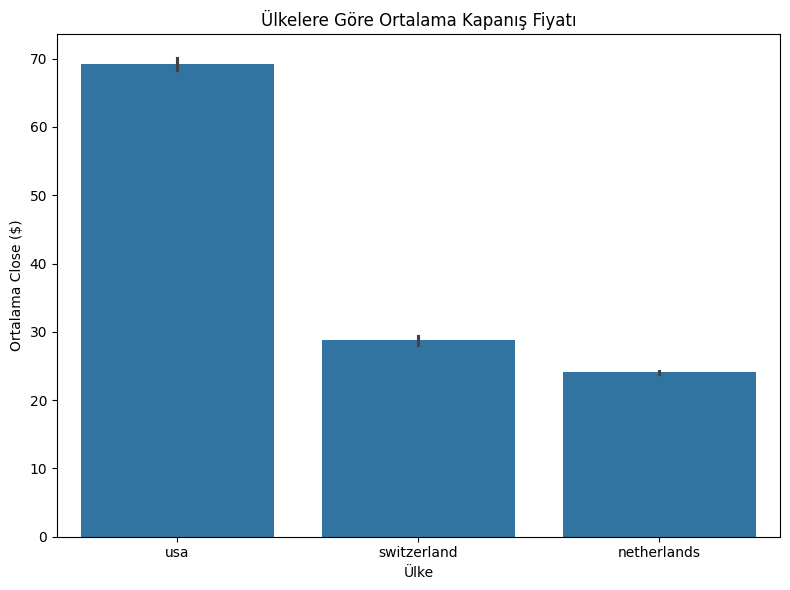

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

tech_df = df[df['Industry_Tag'].str.lower() == 'technology'].copy()
tech_df['Country'] = tech_df['Country'].str.lower()

plt.figure(figsize=(8,6))
sns.barplot(data=tech_df, x='Country', y='Close', estimator='mean')
plt.title('Ülkelere Göre Ortalama Kapanış Fiyatı')
plt.ylabel('Ortalama Close ($)')
plt.xlabel('Ülke')
plt.tight_layout()
plt.show()

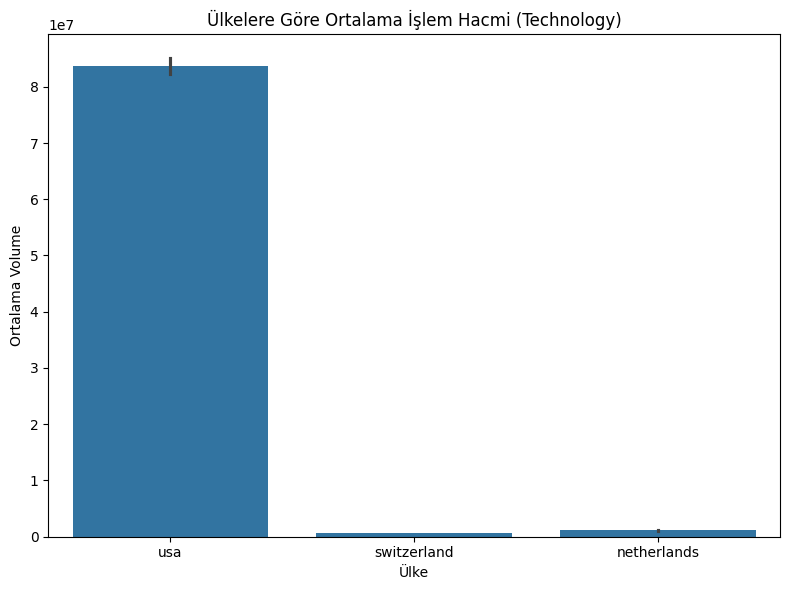

In [27]:
plt.figure(figsize=(8,6))
sns.barplot(data=tech_df, x='Country', y='Volume', estimator='mean')
plt.title('Ülkelere Göre Ortalama İşlem Hacmi (Technology)')
plt.ylabel('Ortalama Volume')
plt.xlabel('Ülke')
plt.tight_layout()
plt.show()

Brand_Name
chipotle                     621.186809
spotify                      228.456895
costco                       186.604307
netflix                      179.866959
coinbase                     170.233807
mastercard                   167.562388
adobe                        154.818408
zoom video communications    145.621448
airbnb                       138.748593
fedex                        126.826153
Name: Close, dtype: float64


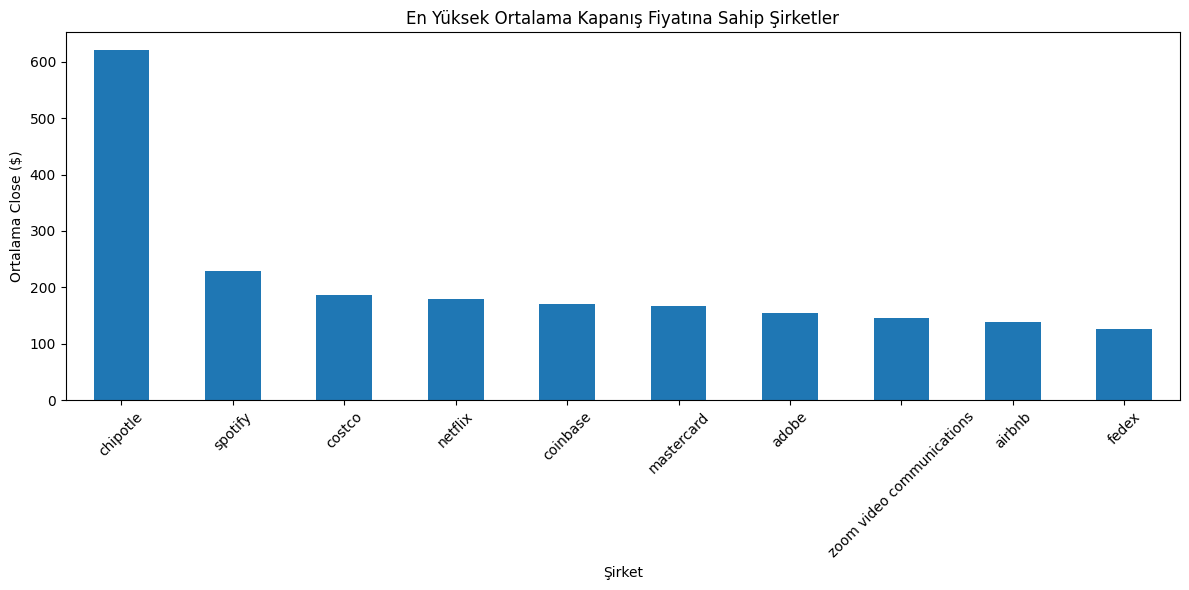

In [28]:
mean_close = df.groupby('Brand_Name')['Close'].mean().sort_values(ascending=False)
print(mean_close.head(10))  # En yüksek ortalamaya sahip 10 şirket
plt.figure(figsize=(12,6))
mean_close.head(10).plot(kind='bar')
plt.title('En Yüksek Ortalama Kapanış Fiyatına Sahip Şirketler')
plt.ylabel('Ortalama Close ($)')
plt.xlabel('Şirket')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Brand_Name
apple                  3.772646e+08
amazon                 1.165622e+08
google                 1.129539e+08
tesla                  9.705898e+07
nvidia                 8.394531e+07
microsoft              4.927211e+07
cisco                  4.174668e+07
amd                    3.397058e+07
uber                   2.393311e+07
jpmorgan chase & co    1.931666e+07
Name: Volume, dtype: float64


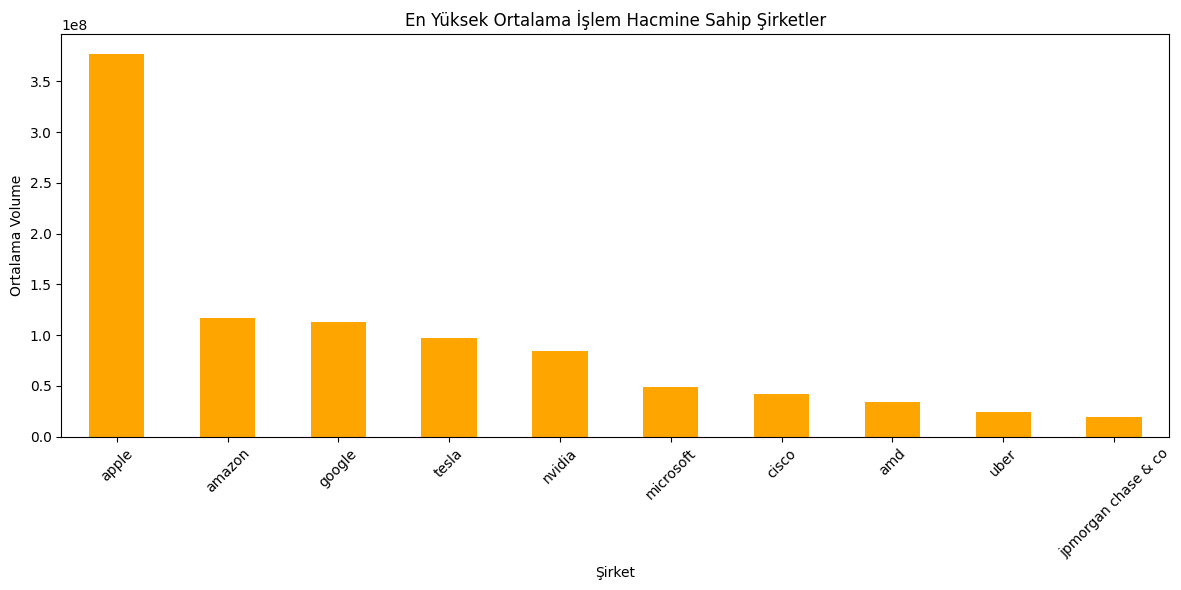

In [29]:
mean_volume = df.groupby('Brand_Name')['Volume'].mean().sort_values(ascending=False)
print(mean_volume.head(10))
plt.figure(figsize=(12,6))
mean_volume.head(10).plot(kind='bar', color='orange')
plt.title('En Yüksek Ortalama İşlem Hacmine Sahip Şirketler')
plt.ylabel('Ortalama Volume')
plt.xlabel('Şirket')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# VERİ ÖN İŞLEME

In [30]:
missing = nvidia_df.isnull().sum()
print("Eksik değer sayısı:\n", missing)

Eksik değer sayısı:
 Open                0
High                0
Low                 0
Close               0
Volume              0
Brand_Name          0
Ticker              0
Industry_Tag        0
Country             0
Dividends           0
Stock Splits        0
Capital Gains    6459
Daily_Return        1
dtype: int64


Model eğitimi için veriyi hazırlıyoruz
* Capital Gains sütunundaki çok sayıda eksik veri nedeniyle bu sütunu kaldırıyoruz
* Daily_Return sütununda sadece 1 eksik değer vardı, onu kaldırmak veri setini fazla etkilemez.


In [31]:
nvidia_df.drop(columns=['Capital Gains'], inplace=True)
nvidia_df.dropna(subset=['Daily_Return'], inplace=True)

In [32]:
missing_rows = nvidia_df[nvidia_df.isnull().any(axis=1)]
print(f"NaN içeren satır sayısı: {len(missing_rows)}")

NaN içeren satır sayısı: 0


# Aykırı Değer (Outlier) Temizleme
**Aykırı değerler model performansını olumsuz etkileyebilir. Temizlenmeleri modelin daha iyi genelleme yapmasını sağlar.**

remove_outliers_iqr fonksiyonu, verilen sütundaki uç değerleri (outlier) IQR yöntemiyle belirleyip temizler:


*  Q1 = %25 çeyrek değer
*  Q3 = %75 çeyrek değer
*  IQR = Q3 - Q1 aralığı


In [33]:
# IQR (Interquartile Range) yöntemiyle outlier belirleme fonksiyonu
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

# Close için outlier temizleme
nvidia_df_no_outliers = remove_outliers_iqr(nvidia_df, 'Close')

# Volume için outlier temizleme
nvidia_df_no_outliers = remove_outliers_iqr(nvidia_df_no_outliers, 'Volume')

# Sonuç
print("Orijinal veri boyutu:", nvidia_df.shape[0])
print("Outlier temizlendikten sonra kalan veri:", nvidia_df_no_outliers.shape[0])


Orijinal veri boyutu: 6458
Outlier temizlendikten sonra kalan veri: 5035


# Veri Ölçeklendirme
kapanış fiyatlarını 0 ile 1 arasına ölçekler.

modelin daha hızlı ve stabil öğrenmesi sağlanır.

In [34]:
from sklearn.preprocessing import MinMaxScaler

# Close sütununu al
close_values = nvidia_df_no_outliers[['Close']].values

# MinMaxScaler oluştur ve fit et
close_scaler = MinMaxScaler()
close_scaled = close_scaler.fit_transform(close_values)


# Zaman Serisi Sekans Oluşturma

***Ölçeklenmiş kapanış fiyatları verisinden, modelin öğrenebilmesi için girdi (X) ve çıktı (y) zaman serisi sekanslarını oluşturmak..***

window_size = 60: Modelin her tahmin için geçmiş 60 günü kullanacağı anlamına gelir.

X: Her örnek için 60 günlük kapanış fiyatı sekansı.

y: Her örneğin karşılık geldiği takip eden günün kapanış fiyatı (hedef).

Döngü window_size dan başlayarak son güne kadar kaydırılarak veri oluşturur.

X ve y numpy dizilerine dönüştürülür.

In [35]:
import numpy as np

# Ölçeklendirilmiş kapanış fiyatları (Close) değerlerini alıyoruz
close_values = close_scaled

# Kullanmak istediğimiz pencere büyüklüğü (örneğin geçmiş 60 gün)
window_size = 60

# Girdi (X) ve çıktı (y) dizilerini oluşturmak için boş listeler
X, y = [], []

# Veride gezinerek her 60 günlük pencereyi bir örnek olarak alıyoruz
for i in range(window_size, len(close_values)):
    # i'nci günün 60 önceki günlerine kadar olan kapanış fiyatları (girdi)
    X.append(close_values[i - window_size:i])
    # i'nci günün kapanış fiyatı (tahmin edilecek çıktı)
    y.append(close_values[i])

# Listeyi numpy array'ine dönüştür (model için uygun format)
X = np.array(X)
y = np.array(y)

# LSTM modelleri 3 boyutlu veri ister: (örnek sayısı, zaman adımı sayısı, özellik sayısı)
# Burada özellik sayısı 1 çünkü sadece kapanış fiyatı var
X = X.reshape((X.shape[0], X.shape[1], 1))

# Veri şekillerini yazdır (kontrol amaçlı)
print("Girdi (X) şekli:", X.shape)
print("Çıktı (y) şekli:", y.shape)

Girdi (X) şekli: (4975, 60, 1)
Çıktı (y) şekli: (4975, 1)


# Eğitim ve Test Setine Bölme

Eğitim seti ile model öğrenir, test seti ise tahmin başarısı

In [36]:
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Eğitim seti şekli: {X_train.shape}, {y_train.shape}")
print(f"Test seti şekli: {X_test.shape}, {y_test.shape}")

Eğitim seti şekli: (3980, 60, 1), (3980, 1)
Test seti şekli: (995, 60, 1), (995, 1)


In [37]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 115.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorfl

# LSTM MODELİ EĞİTİMİ
**LSTM, zaman serisi verilerindeki uzun vadeli bağımlılıkları öğrenmek için tasarlanmış güçlü bir yapay sinir ağı türüdür.
Bu model, kapanış fiyatlarını geçmiş 60 günün verisi ile tahmin etmeye çalışır.**


Model, maksimum 50 epoch (tur) boyunca eğitilir.

Ancak eğitimde EarlyStopping callback'i kullanılır. Eğer doğrulama (validation) kaybı 5 ardışık epoch boyunca iyileşmezse, eğitim otomatik olarak durur ve en iyi ağırlıklar geri yüklenir. Bu sayede aşırı öğrenme (overfitting) engellenir.

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Modeli oluştur
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))  # Tek çıkış, kapanış fiyatı tahmini için

# Modeli derle
model.compile(optimizer='adam', loss='mean_squared_error')

# EarlyStopping: Validation loss iyileşmezse eğitimi durdurur (overfitting önleme)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ModelCheckpoint: En iyi modeli kaydeder
checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)

# Modeli eğit
history = model.fit(
    X_train, y_train,
    epochs=50,                  # erken durdurma ile kontrol sağlanacak
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1426e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 1.1369e-04 - val_loss: 9.5175e-04
Epoch 2/50
119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3841e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.3682e-06 - val_loss: 8.0630e-04
Epoch 3/50
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8038e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7987e-06 - val_loss: 6.8353e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.3347e-06 - val_loss: 9.2759e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0151e-06 - val_loss: 0.0015
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.3031e-06 - val_loss: 7.1228e-04
Epoch 7/50
121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7634e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7444e-06 - val_loss: 5.7039e-04
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9219e-06 - val_loss: 7.8082e-04
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.5705e-06 - val_loss: 0.0010
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.6148e-06 - val_loss: 8.0970e-04
Epoch 11/50
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5839e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5784e-06 - val_loss: 5.5761e-04
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9131e-06 - val_loss: 0.0015
Epoch 13/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9588e-06 - val_loss: 0.0017
Epoch 14/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0093e-06 - val_loss: 0.0019
Epoch 15/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9794e-06 - val_loss: 0.0014
Epoch 16/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6223e-06 - val_loss: 0.0010


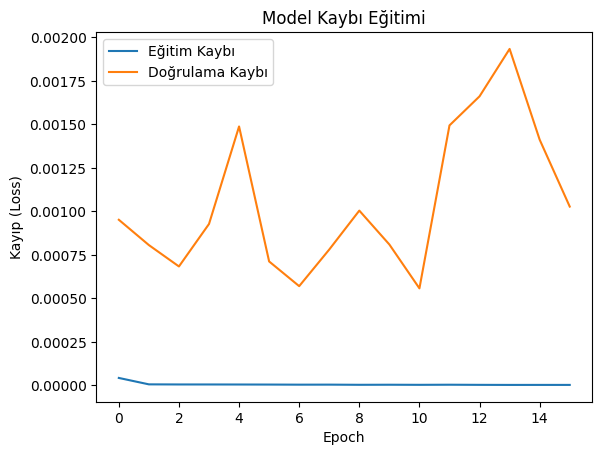

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı Eğitimi')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')
plt.legend()
plt.show()

model tahminlerini orijinal fiyat aralığına geri dönüştürür, gerçek değerlerle karşılaştırır ve performansı hem sayısal hem görsel olarak değerlendirir.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test MSE (orijinal ölçek): 8.61559710761886
Test RMSE (orijinal ölçek): 2.9352337398610797


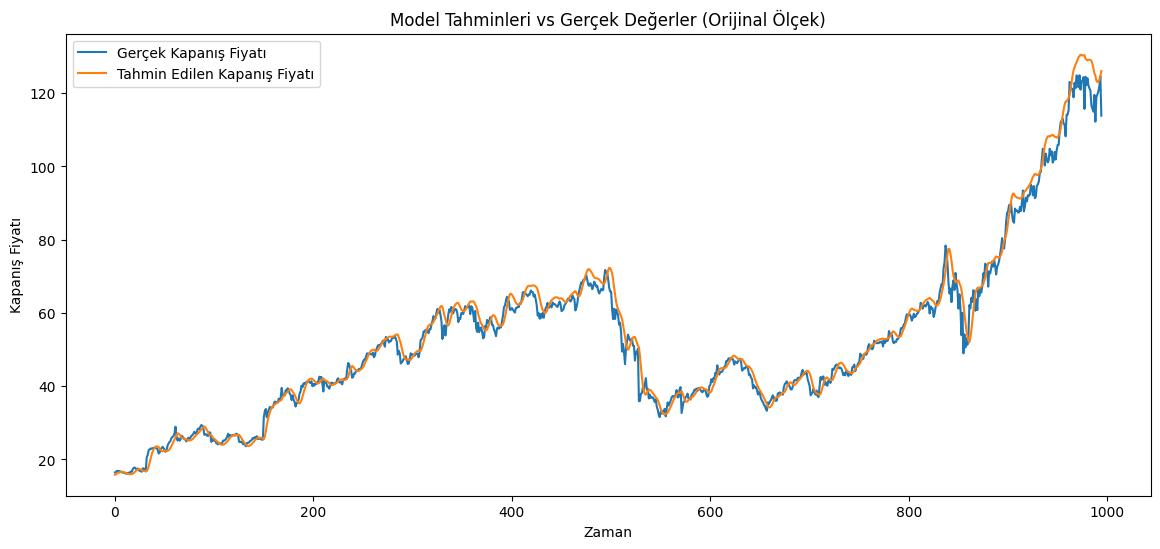

In [50]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Tahmin yap
y_pred = model.predict(X_test)

# Düzgün çalışması için boyutları 2D yap
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

# Ölçeklendirmeyi geri al
y_test_orig = close_scaler.inverse_transform(y_test_reshaped)
y_pred_orig = close_scaler.inverse_transform(y_pred_reshaped)

# Hata hesapla (orijinal ölçekte)
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)

print(f"Test MSE (orijinal ölçek): {mse}")
print(f"Test RMSE (orijinal ölçek): {rmse}")

# Grafikle karşılaştır
plt.figure(figsize=(14,6))
plt.plot(y_test_orig, label='Gerçek Kapanış Fiyatı')
plt.plot(y_pred_orig, label='Tahmin Edilen Kapanış Fiyatı')
plt.title('Model Tahminleri vs Gerçek Değerler (Orijinal Ölçek)')
plt.xlabel('Zaman')
plt.ylabel('Kapanış Fiyatı')
plt.legend()
plt.show()


# SIMPLE RNN MODELİ EĞİTİMİ
Klasik RNN yapısıdır, zaman serisi verisindeki ardışık bağımlılıkları öğrenmek için temel bir yapıdır. kısa dönem bağımlılıkları yakalayabilir.

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Modeli oluştur
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_rnn.add(Dense(1))

# Modeli derle
model_rnn.compile(optimizer='adam', loss='mean_squared_error')

# Modeli eğit
history_rnn = model_rnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 2.7794e-04 - val_loss: 0.0099
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.0267e-06 - val_loss: 0.0099
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9079e-06 - val_loss: 0.0091
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3246e-06 - val_loss: 0.0074
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.3261e-06 - val_loss: 0.0065
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0907e-06 - val_loss: 0.0053
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1620e-06 - val_loss: 0.0043
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1933e-06 - val_loss: 0.0042
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7074e-06 - val_loss: 0.0049
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5555e-06 - val_loss: 0.0047


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Standart RNN Test MSE: 0.004661890206396985
Standart RNN Test RMSE: 0.06827803604671845


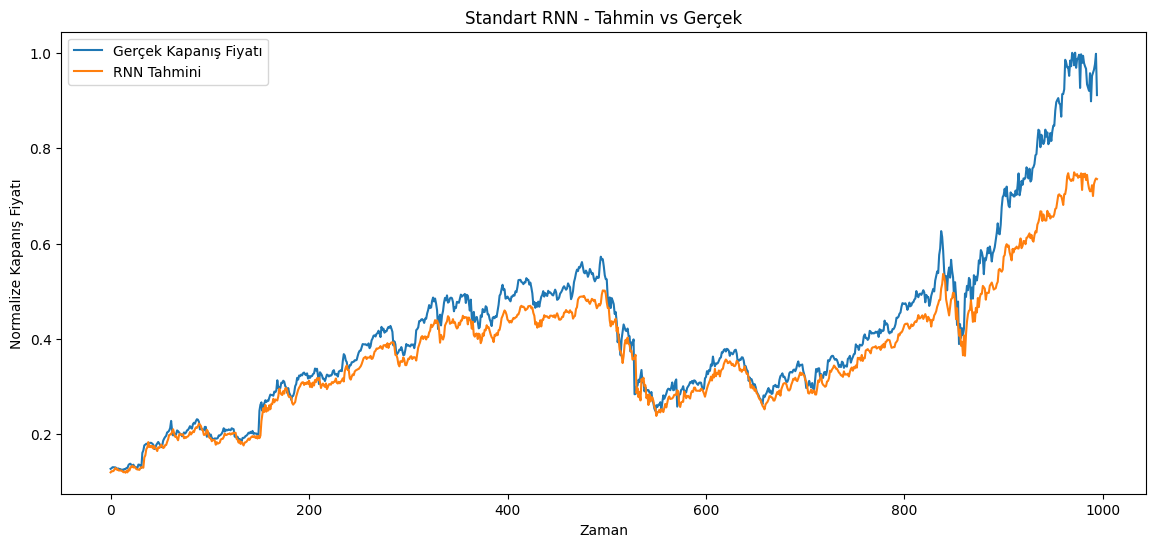

In [42]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Tahmin yap
y_pred_rnn = model_rnn.predict(X_test)

# Performans ölç
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
rmse_rnn = np.sqrt(mse_rnn)

print(f"Standart RNN Test MSE: {mse_rnn}")
print(f"Standart RNN Test RMSE: {rmse_rnn}")

# Sonuçları görselleştir
plt.figure(figsize=(14,6))
plt.plot(y_test, label='Gerçek Kapanış Fiyatı')
plt.plot(y_pred_rnn, label='RNN Tahmini')
plt.title('Standart RNN - Tahmin vs Gerçek')
plt.xlabel('Zaman')
plt.ylabel('Normalize Kapanış Fiyatı')
plt.legend()
plt.show()

# GRU MODELİ EĞİTİMİ
 finansal zaman serisi tahmini için güçlü bir GRU tabanlı model kurar, eğitir ve performansını değerlendirir.

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.4297e-04 - val_loss: 3.5612e-04
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7934e-06 - val_loss: 3.3890e-04
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.4964e-06 - val_loss: 3.2307e-04
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3338e-06 - val_loss: 3.0036e-04
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1240e-06 - val_loss: 2.9664e-04
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3610e-06 - val_loss: 3.5245e-04
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2847e-06 - val_loss: 2.9409e-04
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4256e-06 - val_loss: 2.6562e-04
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9459e-06 - val_loss: 3.0507e-04
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8540e-06 - val_loss: 2.3716e-04
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
GRU Test MSE: 0.00023716419768

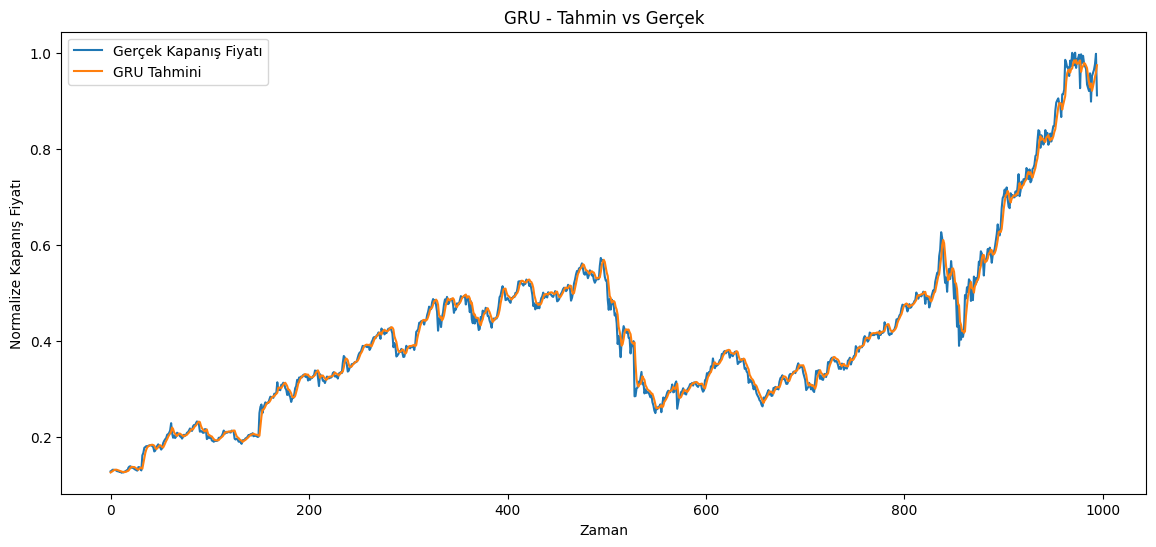

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Modeli oluştur
model_gru = Sequential()
model_gru.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dense(1))

# Modeli derle
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Modeli eğit
history_gru = model_gru.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Tahmin yap
y_pred_gru = model_gru.predict(X_test)

# Performans ölç
mse_gru = mean_squared_error(y_test, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)

print(f"GRU Test MSE: {mse_gru}")
print(f"GRU Test RMSE: {rmse_gru}")

# Sonuçları görselleştir
plt.figure(figsize=(14,6))
plt.plot(y_test, label='Gerçek Kapanış Fiyatı')
plt.plot(y_pred_gru, label='GRU Tahmini')
plt.title('GRU - Tahmin vs Gerçek')
plt.xlabel('Zaman')
plt.ylabel('Normalize Kapanış Fiyatı')
plt.legend()
plt.show()

# BRNN MODEL EĞİTİMİ
Bidirectional RNN modelinin tahmin performansı diğer modellerle karşılaştırıldığında (örneğin GRU veya LSTM) zayıf görünüyor.

Model, gerçek fiyat hareketlerini yeterince iyi takip edememiş

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 5.1400e-04 - val_loss: 0.0211
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6.7319e-06 - val_loss: 0.0244
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.9261e-06 - val_loss: 0.0266
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4776e-06 - val_loss: 0.0288
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.2239e-06 - val_loss: 0.0317
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4574e-06 - val_loss: 0.0344
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0450e-06 - val_loss: 0.0376
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1797e-06 - val_loss: 0.0378
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.4730e-06 - val_loss: 0.0367
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.0199e-06 - val_loss: 0.0400
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Bidirectional RNN Test MSE: 0.039997267641952626
Bidirectional

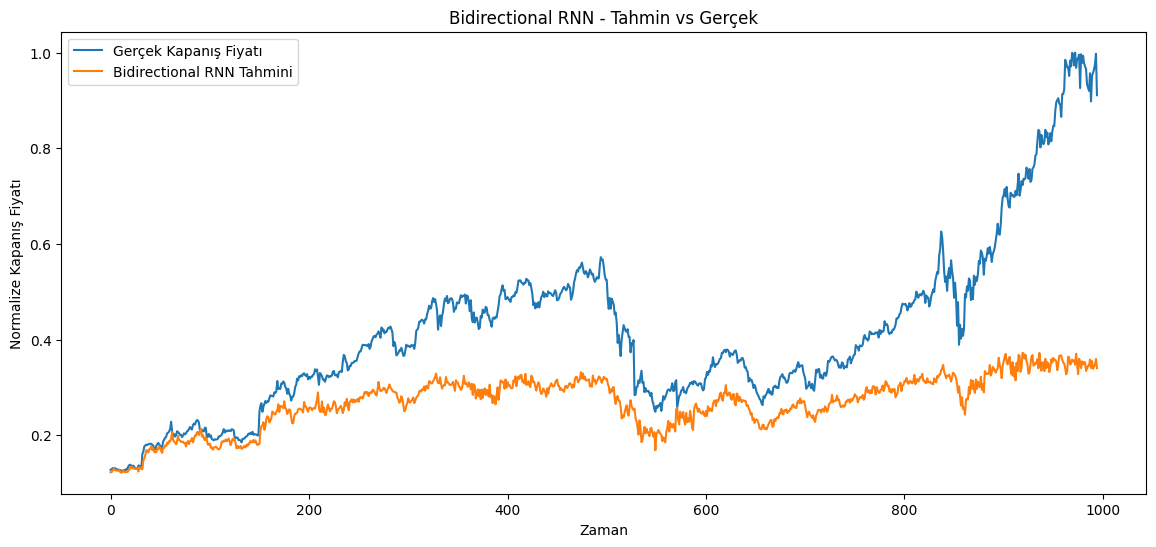

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Bidirectional, Dense
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Modeli oluştur
model_bidir = Sequential()
model_bidir.add(Bidirectional(SimpleRNN(50), input_shape=(X_train.shape[1], X_train.shape[2])))
model_bidir.add(Dense(1))

# Modeli derle
model_bidir.compile(optimizer='adam', loss='mean_squared_error')

# Modeli eğit
history_bidir = model_bidir.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Tahmin yap
y_pred_bidir = model_bidir.predict(X_test)

# Performans ölç
mse_bidir = mean_squared_error(y_test, y_pred_bidir)
rmse_bidir = np.sqrt(mse_bidir)

print(f"Bidirectional RNN Test MSE: {mse_bidir}")
print(f"Bidirectional RNN Test RMSE: {rmse_bidir}")

# Sonuçları görselleştir
plt.figure(figsize=(14,6))
plt.plot(y_test, label='Gerçek Kapanış Fiyatı')
plt.plot(y_pred_bidir, label='Bidirectional RNN Tahmini')
plt.title('Bidirectional RNN - Tahmin vs Gerçek')
plt.xlabel('Zaman')
plt.ylabel('Normalize Kapanış Fiyatı')
plt.legend()
plt.show()

               Model  Test MSE  Test RMSE
0                GRU   0.00025     0.0159
1               LSTM   0.00087     0.0295
2       Standart RNN   0.00270     0.0520
3  Bidirectional RNN   0.15400     0.3930


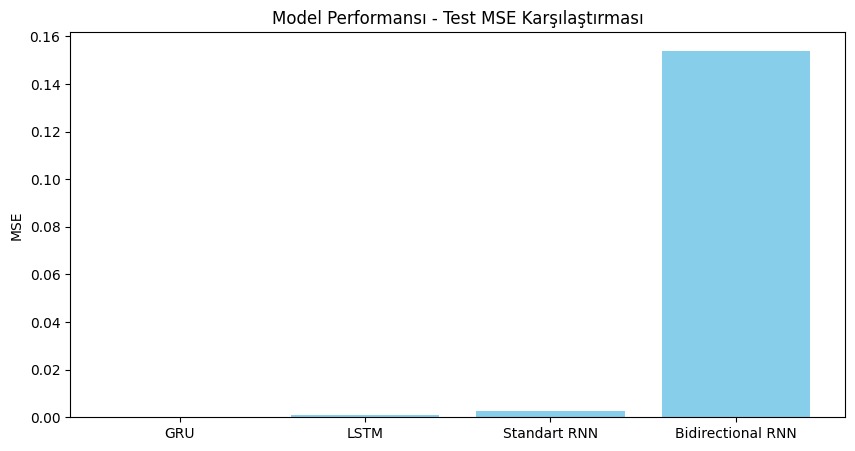

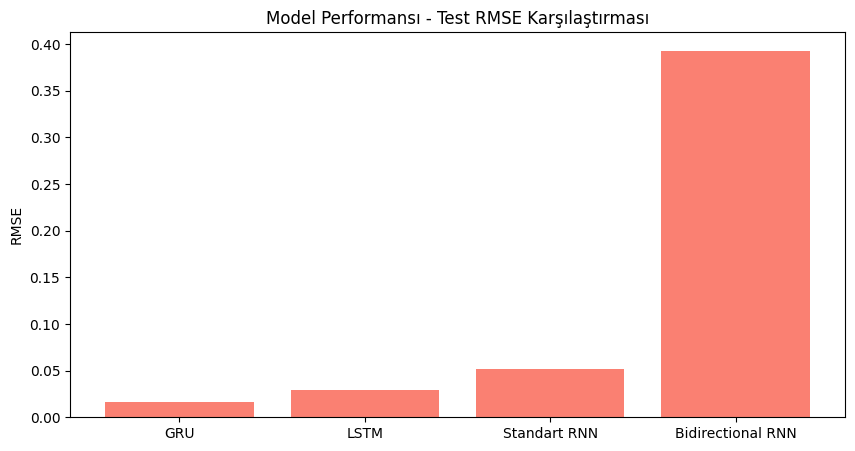

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Performans verileri
data = {
    'Model': ['GRU', 'LSTM', 'Standart RNN', 'Bidirectional RNN'],
    'Test MSE': [0.00025, 0.00087, 0.0027, 0.154],
    'Test RMSE': [0.0159, 0.0295, 0.052, 0.393]
}

df_perf = pd.DataFrame(data)

# Tabloyu yazdır
print(df_perf)

# MSE karşılaştırma grafiği
plt.figure(figsize=(10,5))
plt.bar(df_perf['Model'], df_perf['Test MSE'], color='skyblue')
plt.title('Model Performansı - Test MSE Karşılaştırması')
plt.ylabel('MSE')
plt.show()

# RMSE karşılaştırma grafiği
plt.figure(figsize=(10,5))
plt.bar(df_perf['Model'], df_perf['Test RMSE'], color='salmon')
plt.title('Model Performansı - Test RMSE Karşılaştırması')
plt.ylabel('RMSE')
plt.show()


# FORECASTING - GELECEK HİSSE SENEDİ KAPANIŞINI TAHMİN ETME

rolling forecast (kaydırmalı tahmin) yapar.

Başlangıçta elimizde gerçek veri dizisi var.

Model her seferinde bu diziyi kullanarak 1 adımlık tahmin yapar.

Tahmin, yeni girdiye eklenerek ileriye doğru tahmin yapılmaya devam edilir.

In [46]:
import numpy as np

def forecast_future(model, last_sequence, future_steps):
    current_seq = last_sequence.copy()
    predictions = []

    for _ in range(future_steps):
        pred = model.predict(current_seq)
        predictions.append(pred[0,0])
        current_seq = np.append(current_seq[:,1:,:], [[[pred[0,0]]]], axis=1)

    return np.array(predictions).reshape(-1,1)


In [47]:
future_steps = 10
last_seq = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])

# LSTM tahmini
lstm_preds = forecast_future(model, last_seq, future_steps)

# Standart RNN tahmini
rnn_preds = forecast_future(model_rnn, last_seq, future_steps)

# GRU tahmini
gru_preds = forecast_future(model_gru, last_seq, future_steps)

# Bidirectional RNN tahmini
bidir_preds = forecast_future(model_bidir, last_seq, future_steps)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━

   Gün        LSTM  Standart RNN         GRU  Bidirectional RNN
0    0  126.006721     91.945023  121.621704          42.863827
1    1  127.724457     92.969360  121.640564          43.166763
2    2  129.639709     77.102135  121.440659          35.847580
3    3  131.690552     74.846046  121.181099          43.365761
4    4  133.838058     66.146835  120.905800          29.318962
5    5  136.057404     64.965263  120.628029          36.069572
6    6  138.332184     54.585728  120.352188          26.106813
7    7  140.651138     60.365871  120.079887          11.527101
8    8  143.006088     50.456650  119.811775           2.365207
9    9  145.390808     55.648163  119.548119          13.387647


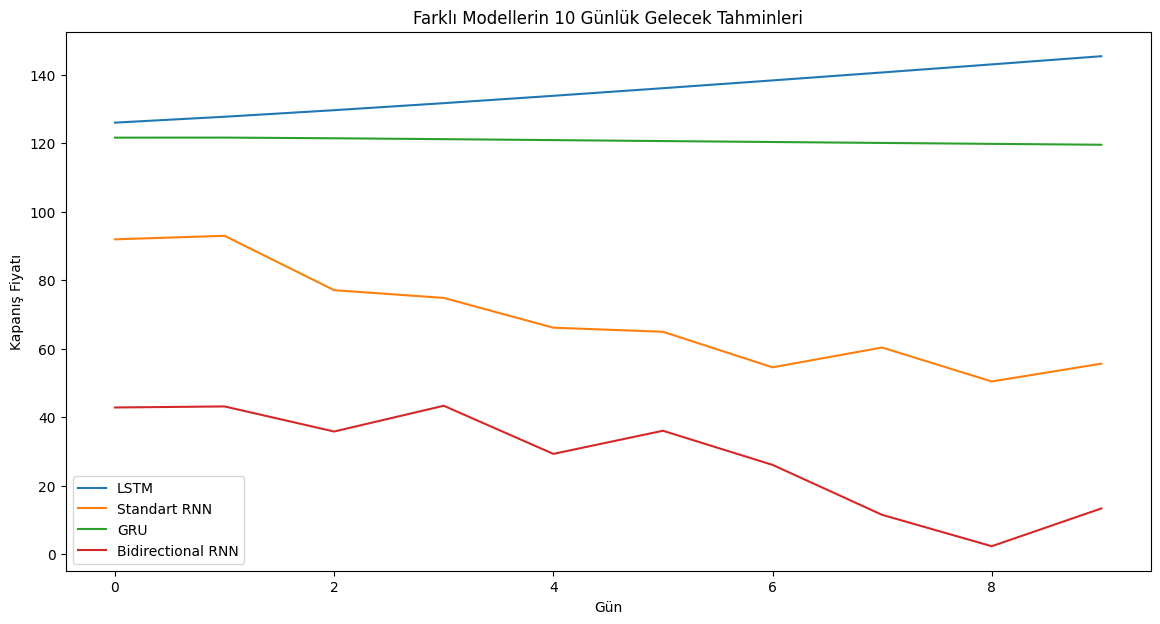

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tahminleri orijinal ölçeğe dönüştür
lstm_preds_orig = close_scaler.inverse_transform(lstm_preds)
rnn_preds_orig = close_scaler.inverse_transform(rnn_preds)
gru_preds_orig = close_scaler.inverse_transform(gru_preds)
bidir_preds_orig = close_scaler.inverse_transform(bidir_preds)

# Gün sayısı
days = np.arange(len(lstm_preds_orig))

# Tabloyu oluştur
df_preds = pd.DataFrame({
    'Gün': days,
    'LSTM': lstm_preds_orig.flatten(),
    'Standart RNN': rnn_preds_orig.flatten(),
    'GRU': gru_preds_orig.flatten(),
    'Bidirectional RNN': bidir_preds_orig.flatten()
})

print(df_preds)

# Grafik çiz
plt.figure(figsize=(14,7))
plt.plot(df_preds['Gün'], df_preds['LSTM'], label='LSTM')
plt.plot(df_preds['Gün'], df_preds['Standart RNN'], label='Standart RNN')
plt.plot(df_preds['Gün'], df_preds['GRU'], label='GRU')
plt.plot(df_preds['Gün'], df_preds['Bidirectional RNN'], label='Bidirectional RNN')
plt.title('Farklı Modellerin 10 Günlük Gelecek Tahminleri')
plt.xlabel('Gün')
plt.ylabel('Kapanış Fiyatı')
plt.legend()
plt.show()
